In [82]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [1]:
import os
import sys
# block warnings from printing
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import collections
import xarray as xr
xr.set_options(keep_attrs=True)
import netCDF4 as nc
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import metpy.calc as mp
from metpy.units import units
from scipy.stats import ttest_ind, ttest_rel
from datetime import datetime

import cartopy
cartopy.config['data_dir'] = "/discover/nobackup/projects/jh_tutorials/JH_examples/JH_datafiles/Cartopy"
cartopy.config['pre_existing_data_dir'] = "/discover/nobackup/projects/jh_tutorials/JH_examples/JH_datafiles/Cartopy"
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.geometry.polygon import LinearRing

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib.colors import TwoSlopeNorm
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import cmocean.cm as cmo


# add path to custom functions
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/py_functions")
# import custom functions
from map_plot_tools import *
from colorbar_funcs import *


# settings
%config InlineBackend.figure_format = 'retina'


In [2]:
### +++ FUNCTIONS +++ ###

## TIME-SERIES MEAN SEASONAL CLIMATOLOGIES ##
def season_mean(ds, calendar='standard'):
    seas_mean = ds.groupby('time.season').mean(dim='time') #sum(dim='time')
    return seas_mean

def annual_mean(ds, calendar='standard'):
    ann_mean = ds.groupby('time.year').mean(dim='time') #sum(dim='time')
    return ann_mean

## ANNUAL SEASONAL MEAN CLIMATOLOGIES ##
def annual_season_mean(ds, calendar='standard'):
    ds_seasonal = {}
    ann_seasonal_mean = {}
    for season in ['DJF','MAM','JJA','SON']:
        # extract data for season
        ds_seasonal[season] = ds.where(ds['time.season'] == season)
        # I'm not sure what this step is doing
        if season == 'DJF':
            ds_seasonal[season] = ds_seasonal[season].shift(time=1)
        # get timeseries of seasonal mean climatologies
        ann_seasonal_mean[season] = ds_seasonal[season].groupby('time.year').mean(dim='time') #sum(dim='time')
        # but, cut first year of DJF timeseries as there is no Dec data from year -1
        if season == 'DJF':
            year_min = ann_seasonal_mean[season].year.min()+1
            year_max = ann_seasonal_mean[season].year.max()
            ann_seasonal_mean[season] = ann_seasonal_mean[season].sel(year=slice(year_min, year_max)) #.isel(year=slice(1,len(ann_seas_mean['DJF'].year)))
    return ann_seasonal_mean


## STATISTICAL SIGNIFICANCE TEST ##
# test with identical sample sizes
def sigtest(yearmean1,yearmean2,timemean1,timemean2):
    ptvals = ttest_rel(yearmean1,yearmean2, axis=0)
    diff = timemean1-timemean2
    diff_mask = np.ma.masked_where(ptvals[1] > 0.1,diff)
    return diff, diff_mask, ptvals

# test with different sample sizes
def sigtest2n(yearmean1,yearmean2,timemean1,timemean2):
    ptvals = ttest_ind(yearmean1,yearmean2, axis=0, equal_var = False)
    diff = timemean1-timemean2
    diff_mask = np.ma.masked_where(ptvals[1] > 0.1,diff)
    return diff, diff_mask, ptvals

def latitude_weighted_mean(var):
    """
    Calculate the mean of geospatial data taking into account unequal grid cell area
    """
    # get x and y coordinate data
    lons,lats = get_xy_coords(var)
    # determine weight based on latitude value
    weights = np.cos(np.deg2rad(lats))
    weights.name = 'weights'
    # calculate area-weighted values
    weighted_var = var.weighted(weights)
    # calculate global mean of weighted data
    weighted_mean = weighted_var.mean(dim=[lats.name,lons.name], keep_attrs=True)
    return(weighted_mean)


def longitude_flip(var):
    """ Convert longitude values from the -180:180 to 0:360 convention or vice versa.
        
        ** Only works for global data. Do not apply to data with a clipped longitude range **
        
        Parameters
        ----------
        var : Data Array
    """    
    # get var info
    x,_=get_xy_coords(var) # extract original longitude values
    lon_name=x.name        # store name of longitude coordinate
    nx=len(x)              # longitude resolution
    
    # determine longitude format and create an array of new lons in opposite convention
    if min(x)<0: 
        # if there are negative values, data is -180:180 and need to switch to 0:360
        new_lons=np.linspace((min(x)+180), (max(x)+180), nx)
    elif max(x)>180:
        # if the max value is >180, data is in 0:360 format and need to switch to -180:180
        new_lons=np.linspace((min(x)-180), (max(x)-180), nx)
        
    # shift the data by 180° of longitude
    nshift=nx//2
    var=var.roll({lon_name: nshift}, roll_coords=False)
            
    # update longitude coord with new values
    var=var.assign_coords({lon_name: new_lons})
    
    # add attributes documenting change
    timestamp=datetime.now().strftime("%B %d, %Y, %r")
    var.attrs['history']=f'flipped longitudes {timestamp}'
    var.attrs['original_lons']=x.values
    
    return(var)

In [3]:
### +++ DATA PATHS +++ ###

runNames=['imerg', 'E2pt1_PIctrl_restart', 'cam.1senv.cpld', 'cam.sam.1senv.cpld', 'maxtopo_E2pt1_PI_restart_new'] # E2.1 cpld simulations
keys=['obs', 'ctrl', 'cam-only', 'cam+sam', 'max-global'] #['obs', 'ctrl', 'cam-only', 'cam+sam', 'max-global'] # product key
diag='pcldl' # diagnostics

# store file paths in dictionary
dpath0='/discover/nobackup/projects/giss/baldwin_nip/dmkumar' # top level data directory
files={}

for i,key in enumerate(keys):
    
    if key in ['obs']:
        files[key] = f'{dpath0}/obs_data/merra2/merra2.CLDLOW.1980-2022.monthly.nc'
        
    elif key in ['ctrl', 'cam-only', 'cam+sam', 'max-global']:
        run=runNames[i]
        files[key] = f'{dpath0}/{run}/timeseries/{diag}_timeseries.{run}.nc'


In [4]:
## ORGANIZE DATA AND CALCULATE CLIMATOLOGIES

# number of years to omit 
omit_yrs = 30
n_omit = omit_yrs * 12
tmax = 350 * 12
latmin = -55
latmax = 30
lonmin = -180
lonmax = -30

# initialize dictionaries
dat = {}
time_mean = {}
ann_mean = {}
seas_mean = {}
ann_seas_mean = {}


## Data cleaning
for key in ['obs']:
    ds = xr.open_dataset(files[key], chunks={}).CLDLOW * 100 # convert from fractional percent
    ds_clip = ds.sel(lat=slice(latmin,latmax), lon=slice(lonmin,lonmax))
    dat[key] = ds_clip
    del ds
    del ds_clip
    
for key in ['ctrl', 'cam-only', 'cam+sam', 'max-global']:
    ds = xr.open_dataset(files[key], chunks={})[diag].isel(time=slice(n_omit,tmax))
    ds_clip = ds.sel(lat=slice(latmin,latmax), lon=slice(lonmin,lonmax))
    dat[key] = ds_clip
    del ds
    del ds_clip
    
## Calculate time-means
print('Calculating time means for...')
for key in ['obs', 'ctrl', 'cam-only', 'cam+sam', 'max-global']:
    print(f'{key}')
    time_mean[key] = dat[key].mean(dim='time')
    ann_mean[key] = annual_mean(dat[key])
    seas_mean[key] = season_mean(dat[key])
    ann_seas_mean[key] = annual_season_mean(dat[key])
print('Done.')

Calculating time means for...
obs
ctrl
cam-only
cam+sam
max-global
Done.


#### calculate significance of mean annual field

In [5]:
## ++ CALCULATE SIGNIFICANCE OF MODEL RUN DIFFERENCES & MASK ++ ##

# initialize dictionaries
diff = collections.defaultdict(dict)
diff_mask = collections.defaultdict(dict)
ptvals = collections.defaultdict(dict)

## COMPARING CONTROL MODEL RUNS WITH E2.1 MODIFIED TOPOGRAPHY RUNS
# For simulations/datasets with the same number of samples
print('Significance testing for...')
for key in ['cam-only', 'cam+sam', 'max-global']:
    print(f'{key}')
    # calculate significance
    diff_, diff_mask_, ptvals_ = sigtest(ann_mean[key], ann_mean['ctrl'],
                                         time_mean[key], time_mean['ctrl'])
    diff[key] = diff_
    diff_mask[key] = diff_mask_
    ptvals[key] = ptvals_
            
#print('Done')


## COMPARING CONTROL MODEL RUNS WITH OBS.
# need to re-grid obs data to E2.1 grid first
regrid= {}
time_mean_regrid = {}
ann_mean_regrid = collections.defaultdict(dict)
lats=time_mean['ctrl'].lat
lons=time_mean['ctrl'].lon

for key in ['obs']:
    print(f'{key}')
    # re-grid time mean obs
    regrid[key] = time_mean[key].interp(lat=lats, lon=lons, method='linear')
    # re-grid seasonal time-mean obs
    time_mean_regrid[key] = time_mean[key].interp(lat=lats, lon=lons, method='linear')
    # re-grid annual seasonal mean obs
    ann_mean_regrid[key] = ann_mean[key].interp(lat=lats, lon=lons, method='linear')
    # calculate significance (not sure why sigtest2n requires adding the '.values' and sigtest function doesn't?)
    diff_, diff_mask_, ptvals_ = sigtest2n(ann_mean_regrid[key].values, ann_mean['ctrl'].values,
                                           time_mean_regrid[key].values, time_mean['ctrl'].values)
    diff[key] = diff_
    diff_mask[key] = diff_mask_
    ptvals[key] = ptvals_
        
print('Done.')


Significance testing for...
cam-only
cam+sam
max-global
obs
Done.


#### calculate significance of seasonal fields

In [10]:
## ++ CALCULATE SIGNIFICANCE OF MODEL RUN DIFFERENCES & MASK ++ ##

# initialize dictionaries
diff = collections.defaultdict(dict)
diff_mask = collections.defaultdict(dict)
ptvals = collections.defaultdict(dict)

seasons = ['DJF','MAM','JJA','SON']


## COMPARING CONTROL MODEL RUNS WITH E2.1 MODIFIED TOPOGRAPHY RUNS
# For simulations/datasets with the same number of samples
print('Significance testing for...')
for key in ['cam-only', 'cam+sam', 'max-global']:
    print(f'{key}')
    # calculate significance
    for season in seasons:
        diff_, diff_mask_, ptvals_ = sigtest(ann_seas_mean[key][season], ann_seas_mean['ctrl'][season],
                                             seas_mean[key].sel(season=season), seas_mean['ctrl'].sel(season=season))
        diff[key][season] = diff_
        diff_mask[key][season] = diff_mask_
        ptvals[key][season] = ptvals_
            
#print('Done')


## COMPARING CONTROL MODEL RUNS WITH OBS.
# need to re-grid obs data to E2.1 grid first
regrid= {}
seas_mean_regrid = {}
ann_seas_mean_regrid = collections.defaultdict(dict)
lats=time_mean['ctrl'].lat
lons=time_mean['ctrl'].lon

for key in ['obs']:
    print(f'{key}')
    # re-grid time mean obs
    regrid[key] = time_mean[key].interp(lat=lats, lon=lons, method='linear')
    # re-grid seasonal time-mean obs
    seas_mean_regrid[key] = seas_mean[key].interp(lat=lats, lon=lons, method='linear')
    # re-grid annual seasonal mean obs
    for season in seasons:
        ann_seas_mean_regrid[key][season] = ann_seas_mean[key][season].interp(lat=lats, lon=lons, method='linear')
        # calculate significance (not sure why sigtest2n requires adding the '.values' and sigtest function doesn't?)
        diff_, diff_mask_, ptvals_ = sigtest2n(ann_seas_mean_regrid[key][season].values, ann_seas_mean['ctrl'][season].values,
                                                seas_mean_regrid[key].sel(season=season).values, seas_mean['ctrl'].sel(season=season).values)
        diff[key][season] = diff_
        diff_mask[key][season] = diff_mask_
        ptvals[key][season] = ptvals_
        
print('Done.')


Significance testing for...
cam-only
cam+sam
max-global
obs
Done.


#### Calculate field differences

In [6]:
## ++ CALCULATE DIFFERENCE OF CLIMATOLOGICAL FIELDS BETWEEN OBS & MODEL RUNS ++ ##

# initialize dictionaries
mdiff = {}
seas_mdiff = {}

print('Calculating field differences.')

for key in ['cam-only', 'cam+sam', 'max-global']: 
    mdiff[key] = time_mean[key] - time_mean['ctrl']
    seas_mdiff[key] = seas_mean[key] - seas_mean['ctrl'] 
print('Done.')

Calculating field differences.
Done.


#### SW Cloud Radiative Forcing Significance

In [7]:
## ORGANIZE DATA AND CALCULATE CLIMATOLOGIES

latmin = -55
latmax = 30
lonmin = -180
lonmax = -30

# initialize dictionaries
sw_time_mean = {}
sw_ann_mean = {}

## Calculate time-means
print('Calculating time means for...')

for key in ['ctrl-amip']:
    print(f'{key}')
    filen = f'{dpath0}/PIctrl_E2.1_AMIP/timeseries/swcrf_toa_timeseries.PIctrl_E2.1_AMIP.nc'
    dat = xr.open_dataset(f'{filen}').swcrf_toa.sel(lat=slice(latmin,latmax), lon=slice(lonmin,lonmax))
    sw_time_mean[key] = dat.mean(dim='time')
    sw_ann_mean[key] = annual_mean(dat)
    
for key in ['obs']:
    print(f'{key}')
    filen = f'{dpath0}/obs_data/CERES_EBAF_Edition4.1_200003-202111.nc'
    dat_ = xr.open_dataset(f'{filen}').toa_cre_sw_mon
    dat_flip = longitude_flip(dat_)
    dat = dat_flip.sel(lat=slice(latmin,latmax), lon=slice(lonmin,lonmax))
    sw_time_mean[key] = dat.mean(dim='time')
    sw_ann_mean[key] = annual_mean(dat)

print('Done.')


## COMPARING CONTROL MODEL RUNS WITH OBS.
print('Significance testing for...')

# initialize dictionaries
sw_diff = collections.defaultdict(dict)
sw_diff_mask = collections.defaultdict(dict)
sw_ptvals = collections.defaultdict(dict)

# need to re-grid obs data to E2.1 grid first
sw_regrid= {}
sw_time_mean_regrid = {}
sw_ann_mean_regrid = collections.defaultdict(dict)
lats=sw_time_mean['ctrl-amip'].lat
lons=sw_time_mean['ctrl-amip'].lon

for key in ['obs']:
    print(f'{key}')
    # re-grid time mean obs
    sw_regrid[key] = sw_time_mean[key].interp(lat=lats, lon=lons, method='linear')
    # re-grid seasonal time-mean obs
    sw_time_mean_regrid[key] = sw_time_mean[key].interp(lat=lats, lon=lons, method='linear')
    # re-grid annual seasonal mean obs
    sw_ann_mean_regrid[key] = sw_ann_mean[key].interp(lat=lats, lon=lons, method='linear')
    # calculate significance (not sure why sigtest2n requires adding the '.values' and sigtest function doesn't?)
    sw_diff_, sw_diff_mask_, sw_ptvals_ = sigtest2n(sw_ann_mean_regrid[key].values, sw_ann_mean['ctrl-amip'].values,
                                                    sw_time_mean_regrid[key].values, sw_time_mean['ctrl-amip'].values)
    sw_diff[key] = sw_diff_
    sw_diff_mask[key] = sw_diff_mask_
    sw_ptvals[key] = sw_ptvals_

print('Done.')

Calculating time means for...
ctrl-amip
obs
Done.
Significance testing for...
obs
Done.


In [8]:
sw_diff['obs'] = sw_time_mean_regrid['obs'] - sw_time_mean['ctrl-amip']

#### Make Fig

In [9]:
### +++ TOPOGRAPHY CONTOURS +++ ###

# e2.1 topo bc info
default=xr.open_dataset(f'{dpath0}/topo_files/Z2HX2fromZ1QX1N.BS1.nc').zatmo
cs1env=xr.open_dataset(f'{dpath0}/topo_files/giss.1s-env.topo.cam.sam.nc').zatmo

# generate topo masks
cs1env_mask=cs1env.where((cs1env-default)>0, 0)
mlons = cs1env_mask.lon
mlats = cs1env_mask.lat

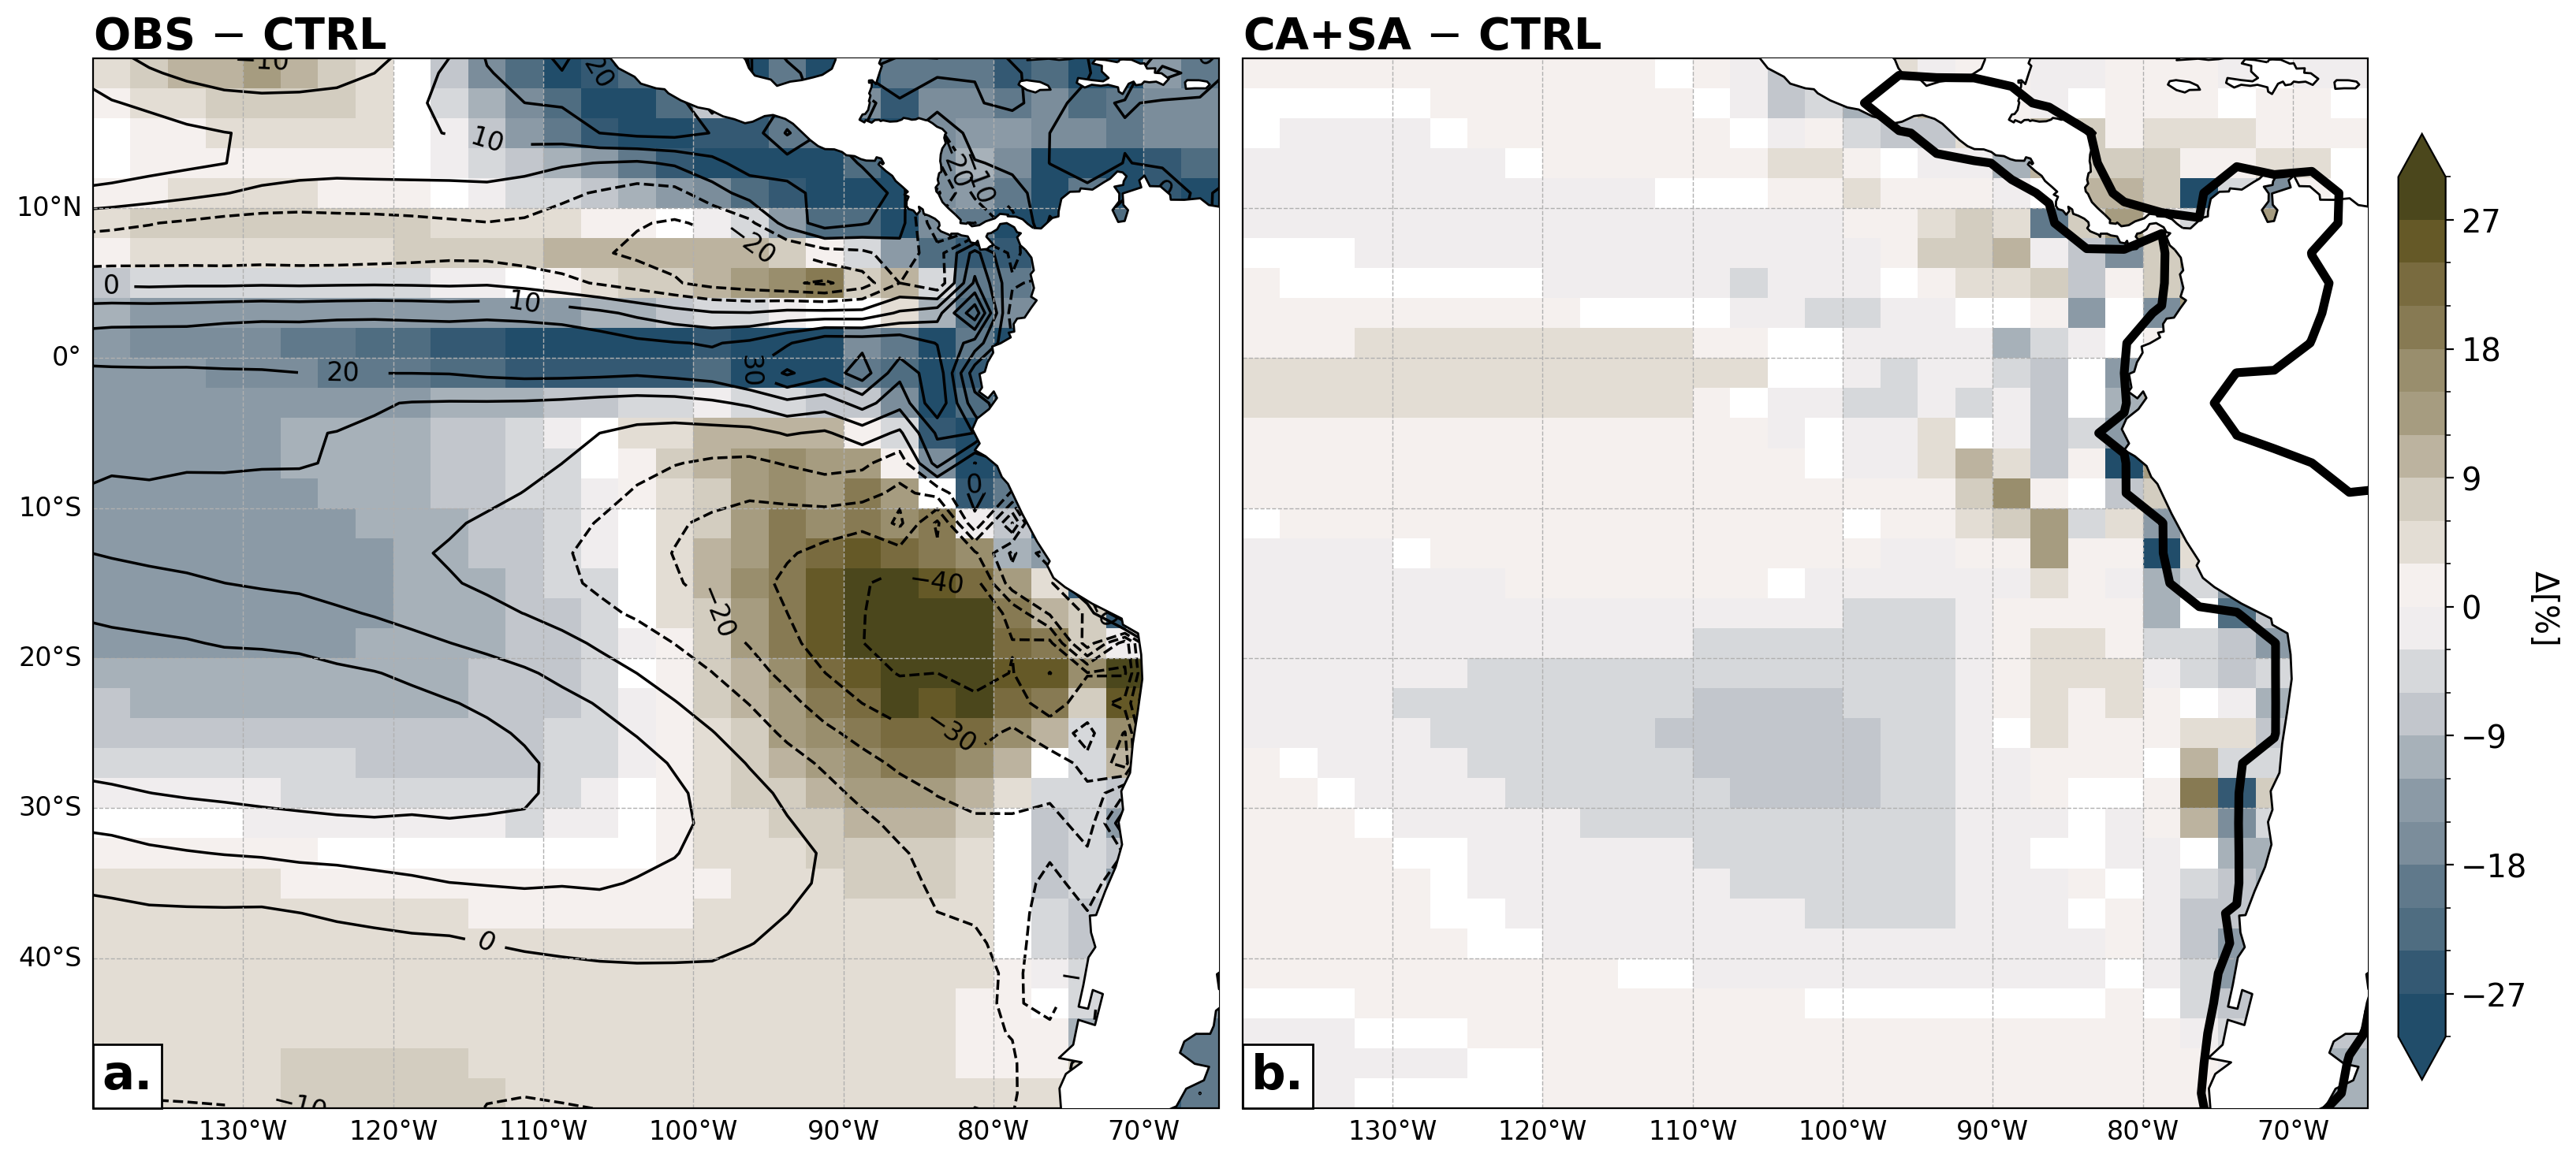

In [16]:
# -------------------- #
#       SETTINGS       #
# -------------------- #
# var info
varn = 'pcldl'
season = 'MAM'
# colormap specs
#cmap,_,_,_=get_settings(field='cloud', diff=True)
#cmap=combine_cmaps(cmo.gray, cmo.ice, range_low=[0.25,1], range_up=[1,0.25], n_low=128, n_up=128)
cmap=clip_cmap(cmo.diff,.1,.9)
vmin=-30
vmax=30
levels=np.linspace(vmin, vmax, 21)
norm=mpl.colors.BoundaryNorm(levels, cmap.N)

# swcrf levels
swlvls=np.linspace(-50, 50, 11)
# text specs
text_kw={'weight': 'bold','ha': 'left','va': 'bottom','color': 'black'}
# map specs
proj=ccrs.PlateCarree(central_longitude=180)
trans=ccrs.PlateCarree()
bounds=map_bnds=[220,295,-50,20]
# label coordinates
tx=40 
ty=20 


# -------------------- #
#          FIG         #
# -------------------- #
fig,ax=plt.subplots(nrows=1, ncols=2, figsize=(15, 10), layout='constrained', subplot_kw={'projection': proj})

# CTRL
ax[0].text(tx,ty,'OBS $-$ CTRL', size=20, **text_kw)
ax[0].pcolormesh(lons, lats, diff_mask['obs'], cmap=cmap, norm=norm, transform=trans)
cs1=ax[0].contour(lons, lats, sw_diff['obs'], levels=swlvls, linewidths=1.25, colors='k', transform=trans)
ax[0].clabel(cs1, cs1.levels, inline=True, inline_spacing=0, fontsize=12)

# CA+SA
ax[1].text(tx,ty,'CA+SA $-$ CTRL', size=20, **text_kw)
ax[1].pcolormesh(lons, lats, diff_mask['cam+sam'], cmap=cmap, norm=norm, transform=trans)
ax[1].contour(mlons, mlats, cs1env_mask, colors='k', linewidths=4, levels=np.linspace(150,10000,2), transform=trans, zorder=50)

    
letters=['a.','b.','c.']
for i, ax in enumerate(ax.flat):
    ax.text(40.6,-49.4, letters[i], size=22, **text_kw,
           bbox=dict(facecolor='white', edgecolor='black'),zorder=100)
    # map properties
    ax.coastlines(color='k', zorder=11, linewidth=1)
    ax.set_extent(map_bnds, crs=trans)
    ax.add_feature(cfeature.LAND, fc='white', zorder=10) #(.8,.8,.8)
    if i==0:
        gl=ax.gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=True)
        gl.bottom_labels=True; gl.left_labels=True; gl.top_labels=False; gl.right_labels=False
    else:
        gl=ax.gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=True)
        gl.bottom_labels=True; gl.left_labels=False; gl.top_labels=False; gl.right_labels=False
    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER
    gl.xlabel_style={'color': 'black', 'weight': 'normal', 'size':12}
    gl.ylabel_style={'color': 'black', 'weight': 'normal', 'size':12}
    
# add colorbar
cf=mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
cax=fig.add_axes([1.01, 0.185, 0.02, 0.6])
cbar=fig.colorbar(cf, orientation='vertical', extend='both', cax=cax)
cbar.set_label('$\Delta$[%]', labelpad=15, rotation=270, size='x-large', fontweight='normal', ha='center')
cbar.ax.tick_params(labelsize='x-large')
for tick in cbar.ax.xaxis.get_major_ticks():
    tick.label1.set_fontweight('normal')
    
plt.savefig(f'swcrf.low_cloud.annual.cpld.masked.pdf', transparent=True, bbox_inches='tight')